In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fairlearn imports
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

In [2]:
# Define DATA_DIR and file names
DATA_DIR = '../data/'
FEATURES_FILE = 'features_to_include.csv'
ALL_DATA_FILE = 'all_data.csv'

# Define bins and labels for age categorization
AGE_BINS = [17, 25, 45, 67]
AGE_LABELS = ['18-25', '25-45', '45-67']

RANDOM_STATE = 42


In [3]:
def load_features(features_path: str) -> list:
    """Load features to exclude based on the inclusion criteria."""
    features_df = pd.read_csv(features_path, delimiter=';')
    excluded = features_df[features_df['Include'] == 0]['Feature (nl)'].tolist()
    print(f"Number of features to exclude: {len(excluded)}")
    return excluded

def classify_features(df: pd.DataFrame) -> pd.DataFrame:
    """Classify features into Binary, Integer, Continuous, or Unknown."""
    summary = []
    for col in df.columns:
        col_data = df[col].dropna()
        unique_vals = set(col_data.unique())
        is_binary = unique_vals.issubset({0, 1})
        is_integer = np.all(np.equal(np.mod(col_data, 1), 0))
        
        if is_binary:
            feature_type = "Binary"
            details = f"Values: {sorted(unique_vals)}"
        elif is_integer:
            feature_type = "Integer"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        elif not is_integer and col_data.dtype.kind in 'fi':  # float or integer
            feature_type = "Continuous"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        else:
            feature_type = "Unknown"
            details = f"Values: {sorted(unique_vals)}"
        
        summary.append({
            'Feature': col,
            'Type': feature_type,
            'Details': details
        })
    
    return pd.DataFrame(summary)

def scale_features(df: pd.DataFrame, feature_names: list) -> pd.DataFrame:
    """Scale specified integer features using MinMaxScaler."""
    scaler = MinMaxScaler()
    df[feature_names] = scaler.fit_transform(df[feature_names])
    return df

def plot_top_features(feature_importance: pd.DataFrame, top_n: int = 30):
    """Plot the top N features based on coefficient magnitude."""
    top_features = feature_importance.head(top_n).iloc[::-1]  # Reverse for better visualization
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Features by Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

In [4]:
# Load features to exclude
features_to_exclude = load_features(f"{DATA_DIR}{FEATURES_FILE}")

# Load all data
data = pd.read_csv(f"{DATA_DIR}{ALL_DATA_FILE}")
print(f"Number of samples: {data.shape[0]}")
print(f"Number of features before exclusion: {data.shape[1]}")

# Drop excluded features
data_copy = data.drop(columns=features_to_exclude)
print(f"Number of features after exclusion: {data_copy.shape[1]}")

# Classify feature types
feature_summary = classify_features(data_copy)

# Find integer features to scale
integer_features = feature_summary[feature_summary['Type'] == 'Integer']['Feature'].tolist()
integer_features = [feat for feat in integer_features if feat != 'persoon_leeftijd_bij_onderzoek']

# Prepare features and target
y = data_copy[['Ja', 'checked']].copy()
X = data_copy.drop(['Ja', 'Nee', 'checked'], axis=1).astype(np.float32)

# Convert boolean target to integers
y['checked'] = y['checked'].astype(int)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y['checked']
)

# Scale integer features
X_train_scaled = scale_features(X_train, integer_features)
X_test_scaled = scale_features(X_test, integer_features)

# Replace original features with scaled features
X_train_scaled = X_train_scaled.copy()
X_test_scaled = X_test_scaled.copy()

Number of features to exclude: 63
Number of samples: 130000
Number of features before exclusion: 318
Number of features after exclusion: 255


In [5]:
district_columns = [
    'adres_recentste_wijk_charlois',
    'adres_recentste_wijk_delfshaven',
    'adres_recentste_wijk_feijenoord',
    'adres_recentste_wijk_ijsselmonde',
    'adres_recentste_wijk_kralingen_c',
    'adres_recentste_wijk_noord',
    'adres_recentste_wijk_other',
    'adres_recentste_wijk_prins_alexa',
    'adres_recentste_wijk_stadscentru'
]

def create_district_feature(df: pd.DataFrame, district_cols: list) -> pd.Series:
    """Create a single categorical 'district' feature as integer codes from one-hot encoded district columns."""
    # Define mapping from district column names to integer codes
    district_map = {
        'adres_recentste_wijk_charlois': 0,
        'adres_recentste_wijk_delfshaven': 1,
        'adres_recentste_wijk_feijenoord': 2,
        'adres_recentste_wijk_ijsselmonde': 3,
        'adres_recentste_wijk_kralingen_c': 4,
        'adres_recentste_wijk_noord': 5,
        'adres_recentste_wijk_other': 6,
        'adres_recentste_wijk_prins_alexa': 7,
        'adres_recentste_wijk_stadscentru': 8
    }
    unknown_code = 9  # Code for unknown districts

    # Check if only one district column is 1 per sample
    if not (df[district_cols].sum(axis=1) <= 1).all():
        raise ValueError("Some samples have multiple districts marked as 1.")

    # Find the district column with value 1
    district_indices = df[district_cols].idxmax(axis=1)

    # Map district column names to integer codes
    districts = district_indices.map(district_map)

    # Handle cases where no district is marked (all zeros)
    districts = districts.where(df[district_cols].sum(axis=1) == 1, unknown_code)

    return districts.astype(int)

# Apply the function to create 'district' feature
X_train_scaled['district'] = create_district_feature(X_train_scaled, district_columns)
X_test_scaled['district'] = create_district_feature(X_test_scaled, district_columns)

# 2. Extract 'gender' feature
# Assuming 'persoon_geslacht_vrouw' is already in X and is binary (0: male, 1: female)
X_train_scaled['gender'] = X_train_scaled['persoon_geslacht_vrouw'].astype(int)
X_test_scaled['gender'] = X_test_scaled['persoon_geslacht_vrouw'].astype(int)

In [6]:
# Categorize age into bins for sensitive feature
train_age_groups = pd.cut(
    X_train_scaled['persoon_leeftijd_bij_onderzoek'],
    bins=AGE_BINS,
    labels=AGE_LABELS,
    right=True
)

test_age_groups = pd.cut(
    X_test_scaled['persoon_leeftijd_bij_onderzoek'],
    bins=AGE_BINS,
    labels=AGE_LABELS,
    right=True
)

# 4. Define sensitive features as a DataFrame
sensitive_features_train = pd.DataFrame({
    'age_group': train_age_groups,
    'gender': X_train_scaled['gender'],
    'district': X_train_scaled['district']
})

sensitive_features_test = pd.DataFrame({
    'age_group': test_age_groups,
    'gender': X_test_scaled['gender'],
    'district': X_test_scaled['district']
})

# 5. Drop the original age and district one-hot features to prevent leakage
X_train_scaled = X_train_scaled.drop(['persoon_leeftijd_bij_onderzoek'] + district_columns + ['persoon_geslacht_vrouw'], axis=1)
X_test_scaled = X_test_scaled.drop(['persoon_leeftijd_bij_onderzoek'] + district_columns + ['persoon_geslacht_vrouw'], axis=1)

# Initialize RidgeClassifier
ridge_classifier = RidgeClassifier(alpha=1.0, random_state=RANDOM_STATE)

In [7]:
# Define the fairness constraint
fairness_constraint = DemographicParity()

# Initialize ExponentiatedGradient with the RidgeClassifier and constraint
exp_grad = ExponentiatedGradient(
    estimator=ridge_classifier,
    constraints=fairness_constraint,
    eps=0.1  # Tolerance for fairness constraint
)

# Fit the model with Fairlearn, providing sensitive features
exp_grad.fit(
    X_train_scaled, 
    y_train['checked'],
    sensitive_features=sensitive_features_train
)

/Users/matthijsvossen/.local/share/virtualenvs/AI-Testing-33-9R5WRaXh/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/Users/matthijsvossen/.local/share/virtualenvs/AI-Testing-33-9R5WRaXh/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:186: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expect_event = self.tags.groupby(_EVENT).mean()
/Users/matthijsvossen/.local/share/virtualenvs/AI-Testing-33-9R5WRaXh/lib/python3.11/site-packages/fairlearn/reduct

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x304025410>,
                      eps=0.1, estimator=RidgeClassifier(random_state=42),
                      nu=0.0005258005733722788)

In [8]:
# Predict on the test set
y_pred = exp_grad.predict(X_test_scaled)

# Evaluate fairness metrics using MetricFrame for Age Group
metric_frame_age = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
        'false_positive_rate': false_positive_rate
    },
    y_true=y_test['checked'],
    y_pred=y_pred,
    sensitive_features=sensitive_features_test['age_group']
)

print("\nOverall Metrics:")
print(metric_frame_age.overall)

print("\nMetrics by Age Group:")
print(metric_frame_age.by_group)

# Evaluate fairness metrics using MetricFrame for Gender
metric_frame_gender = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
        'false_positive_rate': false_positive_rate
    },
    y_true=y_test['checked'],
    y_pred=y_pred,
    sensitive_features=sensitive_features_test['gender']
)

print("\nMetrics by Gender:")
print(metric_frame_gender.by_group)

# Evaluate fairness metrics using MetricFrame for District
metric_frame_district = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
        'false_positive_rate': false_positive_rate
    },
    y_true=y_test['checked'],
    y_pred=y_pred,
    sensitive_features=sensitive_features_test['district']
)

print("\nMetrics by District:")
print(metric_frame_district.by_group)


Overall Metrics:
accuracy               0.860585
selection_rate         0.031354
true_positive_rate     0.139869
false_positive_rate      0.0122
dtype: object

Metrics by Age Group:
           accuracy selection_rate true_positive_rate false_positive_rate
age_group                                                                
18-25      0.576132       0.061728           0.123932            0.003968
25-45      0.784864       0.034957            0.12178            0.007811
45-67        0.9054       0.028836           0.163942            0.014183

Metrics by Gender:
        accuracy selection_rate true_positive_rate false_positive_rate
gender                                                                
0        0.85744        0.03267           0.137539            0.013933
1       0.863964       0.029939           0.142427            0.010344

Metrics by District:
          accuracy selection_rate true_positive_rate false_positive_rate
district                                        

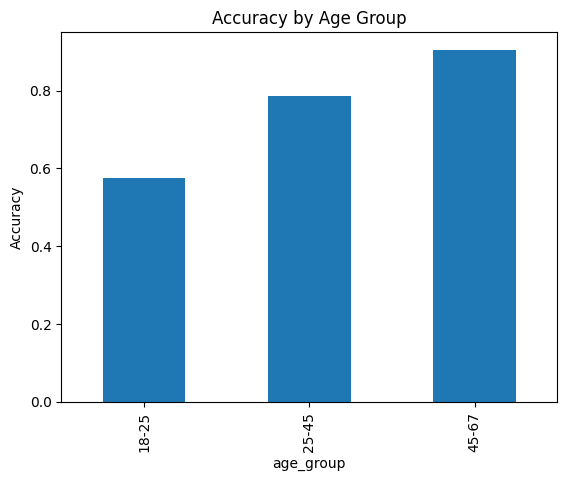

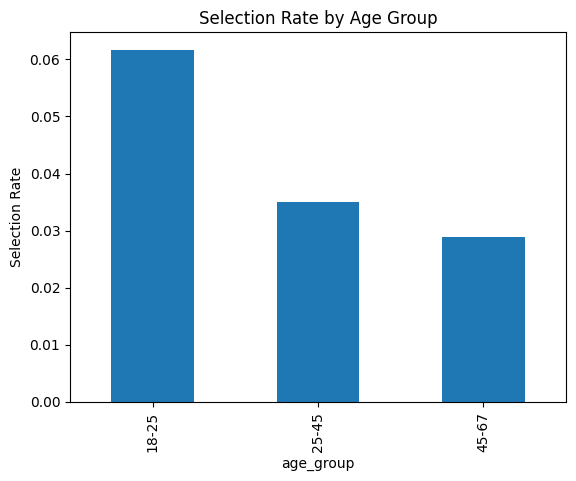

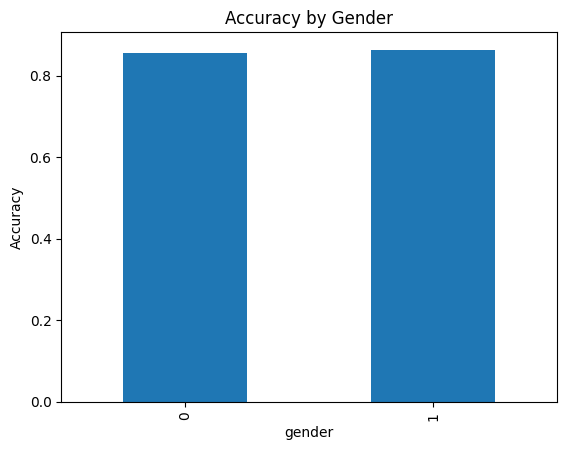

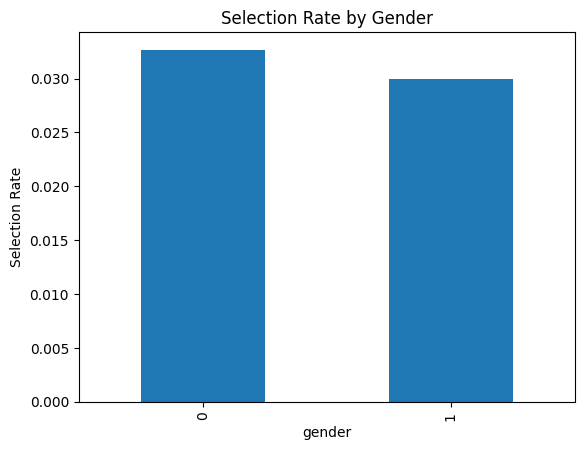

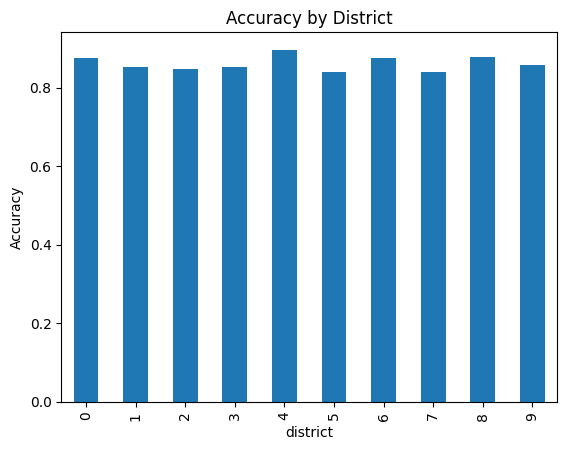

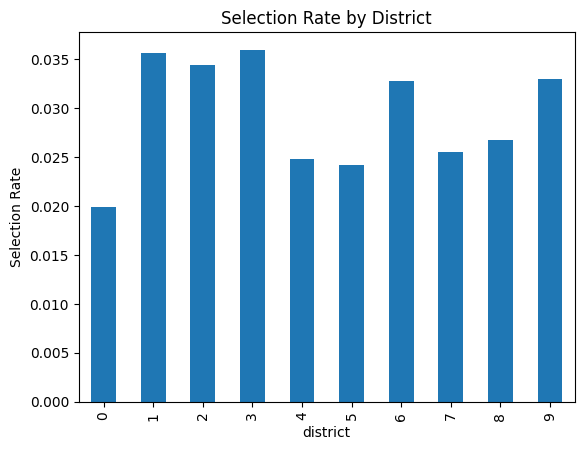

In [9]:
# Optional: Plot fairness metrics for Age Group
metric_frame_age.by_group['accuracy'].plot(kind='bar', title='Accuracy by Age Group')
plt.ylabel('Accuracy')
plt.show()

metric_frame_age.by_group['selection_rate'].plot(kind='bar', title='Selection Rate by Age Group')
plt.ylabel('Selection Rate')
plt.show()

# Optional: Plot fairness metrics for Gender
metric_frame_gender.by_group['accuracy'].plot(kind='bar', title='Accuracy by Gender')
plt.ylabel('Accuracy')
plt.show()

metric_frame_gender.by_group['selection_rate'].plot(kind='bar', title='Selection Rate by Gender')
plt.ylabel('Selection Rate')
plt.show()

# Optional: Plot fairness metrics for District
metric_frame_district.by_group['accuracy'].plot(kind='bar', title='Accuracy by District')
plt.ylabel('Accuracy')
plt.show()

metric_frame_district.by_group['selection_rate'].plot(kind='bar', title='Selection Rate by District')
plt.ylabel('Selection Rate')
plt.show()